In [2]:
import numpy as np
import matplotlib.pyplot as plt

from inversion_tools import *

# Regularised inversion code

Functions are defined in `inversion_tools`. We first define a few parameters, such as the species of interest, and the spectral ranges. We then load up the data, and subset things spectrally.


In [29]:
# Species and spectral bounds (in cm^{-1}) as a dictionary.
bounds = {
    "CO2": (6250, 6600),
    "CH4": [9100, 9700],
    "H2O": [5500, 5900],
    "CO": [2500, 4000],
}
selected_spectra = list(bounds.keys())

(spectra, absorption_spectra, species_names, wv) = read_data(
    selected_spectra,
    "spectra/test_series/", # Location of the series we want to invert.
    "spectra/templates/" # Location of the individual species "template" absorption
)
# Simple background removal and subsetting.
passer, residual_spectra = remove_background(spectra, bounds, wv)
# Subsetting of the absorption spectra.
reference_spectra = absorption_spectra[:, passer]

100%|██████████| 4/4 [00:00<00:00, 47.08it/s]


# One by one inversion

This is how you invert individual timesteps (or individual spectra for that matter).

Shown for the two first time steps and timesteps 300 and 350

In [30]:
for tstep in [0, 1, 300, 350]:
    x_sol = np.linalg.lstsq(reference_spectra.T, residual_spectra[tstep, :], rcond=None)
    print(tstep, "=>", x_sol[0])


0 => [146.82648913  17.16639684 316.31823798 934.64896423]
1 => [148.41638574  17.30635016 316.86252019 997.84931362]
300 => [ 196.5771929    29.0452366   486.01612749 1449.60143927]
350 => [ 179.04432312   29.09006493  474.12971987 1261.1691429 ]


# Regularised inversion

Now for the regularised inversion. This also returns uncertainty (not complete, as I don't really know what the observational error in the data is). Note that the function returns the variance of the posterior distribution, so we need to take the square root. Here I plot the maximum a posteriori and $\pm \sigma/2$, for good measure.



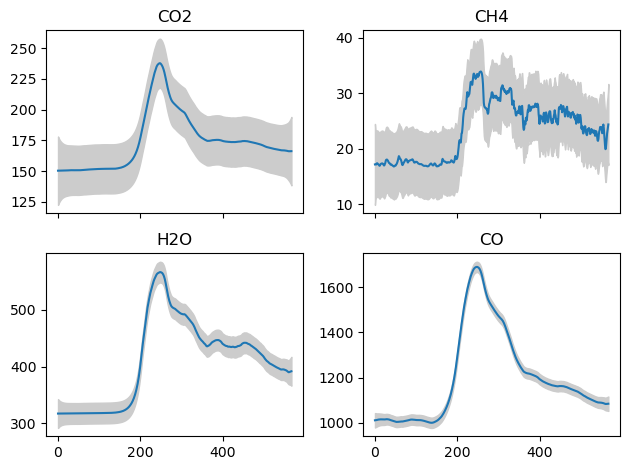

In [114]:
x_sol,sigma, C = temporally_regularised_inversion(reference_spectra, residual_spectra,
                                                  0.005)
fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True)
axs = axs.flatten()
nt = residual_spectra.shape[0]

for i, spc in enumerate(selected_spectra):
    axs[i].plot(np.arange(nt), x_sol[i*nt:(i+1)*nt])
    axs[i].fill_between(np.arange(nt), x_sol[i*nt:(i+1)*nt] - 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                        x_sol[i*nt:(i+1)*nt] + 0.5*np.sqrt(sigma[i*nt:(i+1)*nt]),
                        color= "0.8")
    axs[i].set_title(spc)
fig.tight_layout()

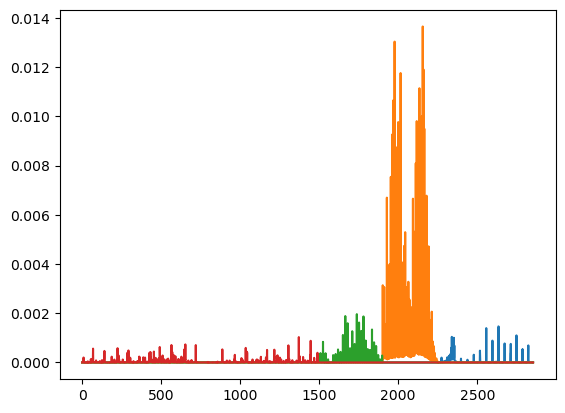

In [116]:
for x in reference_spectra:
    plt.plot(x)